In [5]:
# Check if python is 3.9.5
import arrow
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import __init__

print(sys.version)
%load_ext autoreload
%autoreload 2
%pprint
%matplotlib inline

3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pretty printing has been turned ON


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Rarely cultivated European plants

At first we load species distribution, cultivation and threat data.

In [3]:
plants_dist_file = "../../cache/euro_med_distribution.csv"
plants_threat_file = "../../cache/red_list_european_plants.csv"
plants_cult_file = "../../cache/bgci_species_europe.csv"

In [4]:
p_dist_df = pd.read_csv(plants_dist_file)
p_threat_df = pd.read_csv(plants_threat_file)
p_cult_df = pd.read_csv(plants_cult_file)

We only analyze plants that are native endemic or extinct in europe+mediterranean.

In [5]:
p_native_df = p_dist_df[
    p_dist_df.apply(lambda x : any(x.isin(["native", "endemic", "presumably extinct"])), axis=1)]

In [6]:
p_nat_in_bg_df = pd.merge(p_cult_df, p_native_df, on="euro_med_id")

For simplicity we only look at species (no subspecies / variants) that are "Accepted", "Unassessed" or "-" by BGCI.

In [7]:
p_nat_accpt_in_bg_df = p_nat_in_bg_df[
    p_nat_in_bg_df["status"].isin(["Unassessed", "Accepted", "-"])]

In [8]:
p_nat_accpt_in_bg_only_sp_df = p_nat_accpt_in_bg_df[
    p_nat_accpt_in_bg_df["epithet_rank"].isna()]
p_nat_accpt_in_bg_only_sp_df = p_nat_accpt_in_bg_only_sp_df[
    p_nat_accpt_in_bg_only_sp_df["epithet"].isna()]

## Presence in collections

With this dataset of native european/mediterranean plants, we can look for species that are highly present.

In [9]:
total_n_species = len(p_nat_accpt_in_bg_only_sp_df["n_collections"])
not_in_culture = np.sum(p_nat_accpt_in_bg_only_sp_df["n_collections"]==0)
median_n_collections = np.median(p_nat_accpt_in_bg_only_sp_df["n_collections"][p_nat_accpt_in_bg_only_sp_df["n_collections"]>0])

print(f"Of all {total_n_species} accounted species, {not_in_culture} are nowhere cultivated. "
      f"All the others are cultivated in medial {median_n_collections} collections.")

Of all 10878 accounted species, 1244 are nowhere cultivated. All the others are cultivated in medial 4.0 collections.


This is a table showing all plants that we consider here:

In [11]:
important_columns = ["genus", "species", "n_collections", "euro_med_id", "bgci_id", "iucn_red_list"]
p_nat_accpt_in_bg_only_sp_df.loc[:, important_columns]

genus                species  n_collections  \
0                 Isoetes                azorica              2   
1                 Isoetes                boryana              0   
2                 Isoetes                durieui              2   
3                 Isoetes            echinospora              5   
11                Isoetes               fluitans              0   
12                Isoetes            heldreichii              0   
14                Isoetes              lacustris              9   
17                Isoetes               olympica              0   
18                Isoetes                setacea              2   
19               Huperzia                arctica              1   
20               Huperzia                dentata              2   
21               Huperzia                 selago             25   
28               Huperzia              suberecta              1   
29           Lycopodiella                 cernua             10   
32           Lycopodiella               inundata              9   
33             Lycopodium                alpinum              1   
35             Lycopodium               clavatum             25   
47             Lycopodium            complanatum              4   
55             Lycopodium                issleri              0   
60             Lycopodium               zeilleri              0   
61            Selaginella               balansae              0   
63            Selaginella              helvetica             20   
64            Selaginella           selaginoides             12   
65              Equisetum                arvense             89   
71              Equisetum             fluviatile             36   
74              Equisetum                hyemale            138   
87              Equisetum               palustre             21   
90              Equisetum               pratense             16   
91              Equisetum           ramosissimum             29   
95              Equisetum             scirpoides             57   
96              Equisetum             sylvaticum             23   
98              Equisetum              telmateia             32   
103             Equisetum             variegatum             39   
114            Botrychium                boreale              2   
116            Botrychium            lanceolatum              3   
122            Botrychium                lunaria             19   
126            Botrychium       matricariifolium              2   
128            Botrychium             multifidum              9   
135            Botrychium                simplex              3   
140            Botrychium            virginianum             20   
142          Ophioglossum               azoricum              1   
143          Ophioglossum            lusitanicum              7   
147          Ophioglossum            polyphyllum              2   
148          Ophioglossum               vulgatum             30   
155              Psilotum                  nudum            138   
159               Culcita             macrocarpa             10   
160         Hymenophyllum              maderense              0   
161         Hymenophyllum            tunbrigense              6   
163           Trichomanes              speciosum             16   
165               Osmunda                regalis            194   
177             Asplenium            aethiopicum             20   
181             Asplenium                 anceps              2   
184             Asplenium               azoricum              1   
186             Asplenium          daghestanicum              1   
187             Asplenium                 fissum              1   
190             Asplenium             foreziense              3   
191             Asplenium             hemionitis             17   
193             Asplenium            jahandiezii              0   
195             Asplenium              monanthes              5   


In [10]:
p_nat_threat_df = pd.merge(p_nat_accpt_in_bg_only_sp_df, p_threat_df, how="inner", on="euro_med_id")

In addition, we modify the dataset, such that each row lists the presence of a species within a country.

In [11]:
country_keys = ['Ab', 'Eg', 'Lu', 'AE', 'Es', 'Ma', 'Ag', 'Fa', 'Mk', 'Al', 'Fe', 'Md', 'Ar', 'Ga', 'Mo', 'Au', 'Ge', 
                'No', 'Az', 'Gg', 'Po', 'Be', 'Gr', 'Rf', 'BH', 'Hb', 'Rm', 'Bl', 'He', 'Sa', 'Br', 'Hs', 'Sb', 'Bt',
                'Ho', 'Sg', 'Bu', 'Hu', 'Si', 'By', 'IJ', 'Sk', 'Ca', 'Ir', 'Sl', 'Cc', 'Is', 'Sn', 'Cg', 'It', 'Sr',
                'Co', 'Jo', 'Su', 'Cr', 'La', 'Sy', 'Cs', 'Le', 'Tcs', 'Ct', 'Li', 'Tn', 'Cy', 'LS', 'Tu', 'Da', 'Lt',
                'Uk', 'UC', 'Se']
other_keys = [k for k in p_nat_threat_df.keys() if k not in country_keys]

p_nat_threat_melted_df = pd.melt(
    p_nat_threat_df, id_vars=other_keys, value_vars=country_keys, var_name="country", value_name="distribution")
p_nat_threat_melted_df = p_nat_threat_melted_df[
    p_nat_threat_melted_df["distribution"] != "missing"]

## Many mediterranean species are threatened and rarely cultivated

Let us see, which species are extinct:

In [12]:
p_nat_threat_melted_df[p_nat_threat_melted_df["category"].isin(["EW", "EX"])].sort_values(by="genus_x")

bgci_id hybrid_genus     genus_x hybrid_species           species  \
72654    392512          NaN  Astragalus            NaN      nitidiflorus   
31117     62428          NaN      Bromus            NaN        bromoideus   
49453     62428          NaN      Bromus            NaN        bromoideus   
70083     41825          NaN      Bromus            NaN       interruptus   
79251     41825          NaN      Bromus            NaN       interruptus   
156066    63872          NaN   Centaurea            NaN  pseudoleucolepis   
62326     31210          NaN  Lysimachia            NaN      minoricensis   
31745    682105          NaN       Viola            NaN            cryana   

       epithet_rank epithet    status  n_collections        iucn_red_list  \
72654           NaN     NaN  Accepted              0              Extinct   
31117           NaN     NaN         -              6  Extinct in the Wild   
49453           NaN     NaN         -              6  Extinct in the Wild   
70083           NaN     NaN  Accepted             13  Extinct in the Wild   
79251           NaN     NaN  Accepted             13  Extinct in the Wild   
156066          NaN     NaN  Accepted              2              Extinct   
62326           NaN     NaN  Accepted             35  Extinct in the Wild   
31745           NaN     NaN         -              0              Extinct   

       iucn_red_list_1997 cites                           euro_med_id  \
72654                 NaN   NaN  f14cda78-2b79-41b5-91ba-9507e9003655   
31117                 NaN   NaN  65ce3ded-0950-4b3b-80d3-1087e7d8e09e   
49453                 NaN   NaN  65ce3ded-0950-4b3b-80d3-1087e7d8e09e   
70083             Extinct   NaN  a786d8f7-6750-4238-afd4-155495cc1a19   
79251             Extinct   NaN  a786d8f7-6750-4238-afd4-155495cc1a19   
156066         Endangered   NaN  e186ef83-684e-4fb6-b634-176cebbe7037   
62326          Endangered   NaN  3843debe-802c-4b1c-a3d6-504016857073   
31745                 NaN   NaN  816b23d9-7811-4819-b605-3332bd5dace7   

                          date_fetched_x                    date_fetched_y  \
72654   2022-05-24T18:22:17.751177+02:00  2022-06-01T03:34:45.976378+02:00   
31117   2022-05-24T17:44:16.907426+02:00  2022-06-01T01:15:48.405600+02:00   
49453   2022-05-24T17:44:16.907426+02:00  2022-06-01T01:15:48.405600+02:00   
70083   2022-05-24T17:44:20.282605+02:00  2022-06-01T01:15:54.243882+02:00   
79251   2022-05-24T17:44:20.282605+02:00  2022-06-01T01:15:54.243882+02:00   
156066  2022-05-24T15:33:12.012047+02:00  2022-05-31T12:37:45.609209+02:00   
62326   2022-05-24T16:22:36.321671+02:00  2022-05-31T12:54:36.268947+02:00   
31745   2022-05-24T18:42:26.816453+02:00  2022-06-01T05:09:57.873478+02:00   

                            date_fetched  taxonid             scientific_name  \
72654   2022-05-31T18:46:47.017246+02:00    61652     Astragalus nitidiflorus   
31117   2022-05-31T13:06:09.269960+02:00   165228           Bromus bromoideus   
49453   2022-05-31T13:06:09.269960+02:00   165228           Bromus bromoideus   
70083   2022-05-31T13:06:14.521367+02:00   165247          Bromus interruptus   
79251   2022-05-31T13:06:14.521367+02:00   165247          Bromus interruptus   
156066  2022-05-30T17:37:29.823908+02:00   165235  Centaurea pseudoleucolepis   
62326   2022-05-30T22:52:07.823570+02:00    61670     Lysimachia minoricensis   
31745   2022-05-31T22:17:39.211578+02:00   165210                Viola cryana   

        kingdom        phylum          class         order       family  \
72654   PLANTAE  TRACHEOPHYTA  MAGNOLIOPSIDA       FABALES     FABACEAE   
31117   PLANTAE  TRACHEOPHYTA     LILIOPSIDA        POALES      POACEAE   
49453   PLANTAE  TRACHEOPHYTA     LILIOPSIDA        POALES      POACEAE   
70083   PLANTAE  TRACHEOPHYTA     LILIOPSIDA        POALES      POACEAE   
79251   PLANTAE  TRACHEOPHYTA     LILIOPSIDA        POALES      POACEAE   
156066  PLANTAE  TRACHEOPHYTA  MAGNOLIOPSIDA     ASTERALES   ASTERACEAE   
6232

There may be an issue (probably a taxonomical ambiguity) with the status of *Centaurea pseudoleucolepis*. It appears to be extinct but present in 2 collections.

### *But let us focus on critically endangered plants ("CR")*

We check how often such critically endangered plants are cultivated.

In [13]:
cr_plants_melt_df = p_nat_threat_melted_df[p_nat_threat_melted_df["category"].isin(["CR"])]

In [14]:
cr_per_countries = cr_plants_melt_df.loc[:, ["n_collections", "country", "distribution"]]

<AxesSubplot:xlabel='country', ylabel='Count'>

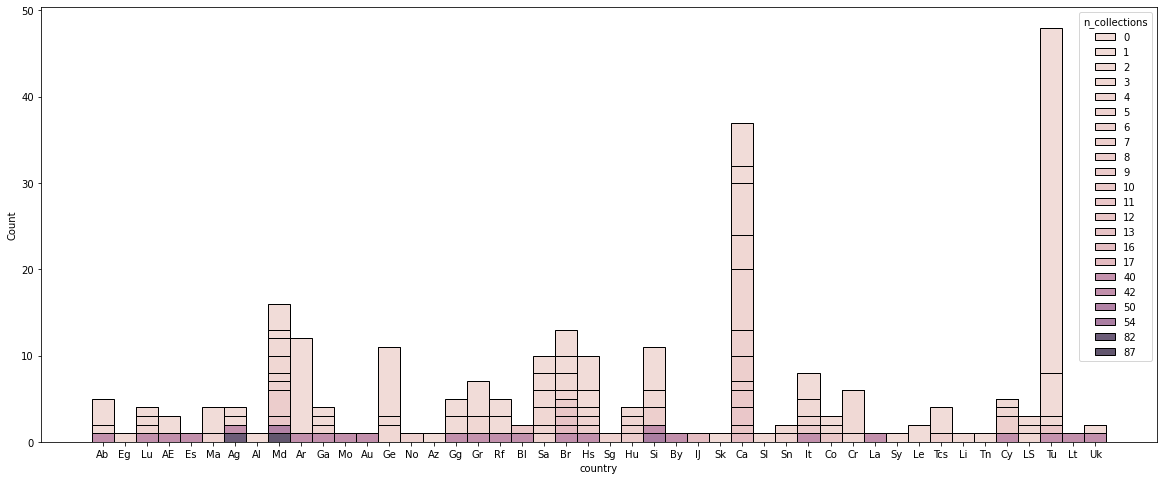

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.histplot(data=cr_per_countries, ax=ax, stat="count", multiple="stack",
             x="country", kde=False, hue="n_collections",
             element="bars", legend=True)

It seems, there are many candidate species in Türkije, Canary islands, Madeira, Armenia, the United Kingdom, Germany, ... Here is a list:

In [63]:
important_columns = ["genus_x", "species", "n_collections", "euro_med_id", "bgci_id", "iucn_red_list",
                     "category", "population_trend"]

cr_plants_melt_concat_dist_df = cr_plants_melt_df.loc[:, important_columns].drop_duplicates()
cr_plants_melt_concat_dist_df["countries"] = cr_plants_melt_df["euro_med_id"].apply(
    lambda x : ", ".join(cr_plants_melt_df["country"][cr_plants_melt_df["euro_med_id"]==x]))

In [56]:
cr_plants_melt_concat_dist_df.sort_values(by=["countries", "n_collections"])

genus_x            species  n_collections  \
6880          Isoetes        heldreichii              0   
8305        Consolida              samia              0   
1571       Astragalus          igniarius              0   
1583       Astragalus     schachbuzensis              0   
1735        Trifolium           bobrovii              0   
1776         Lathyrus           odoratus             42   
26          Asplenium      daghestanicum              1   
14106       Pulicaria       filaginoides              0   
15555           Vicia            fulgens              1   
16025           Abies           numidica             82   
21784          Tulipa           albanica              1   
27716       Centaurea     caroli-henrici              0   
27733       Centaurea          vavilovii              0   
27834         Sonchus         araraticus              0   
28186          Silene         chustupica              0   
28626       Colchicum           greuteri              0   
29091      Astragalus            bylowae              0   
29554      Potentilla       seidlitziana              0   
29577           Pyrus          voronovii              0   
29595           Rubus       takhtadjanii              0   
28142       Verbascum    transcaucasicum              0   
41297       Grammitis            azorica              0   
62002        Naufraga          balearica             12   
70872          Sorbus       cheddarensis              0   
70881          Sorbus       eminentoides              0   
70934          Sorbus           saxicola              0   
70933          Sorbus       rupicoloides              1   
70943          SORBUS        stirtoniana              1   
70922          SORBUS    pseudomeinichii              2   
70953          Sorbus           whiteana              2   
70914          SORBUS          parviloba              4   
70777     Cotoneaster          cambricus              8   
70903          Sorbus             leyana             12   
70952          Sorbus             vexans             13   
70920          Sorbus      pseudofennica             17   
96501    Cheirolophus      santos-abreui              0   
97753          Crambe           feuillei              0   
97957           Lotus         eremiticus              0   
98492     Kunkeliella       psilotoclada              0   
98493     Kunkeliella      subsucculenta              0   
96590         Sonchus          gandogeri              1   
96788       Sideritis           marmorea              1   
96500    Cheirolophus        metlesicsii              2   
96539       Onopordum         carduelium              2   
96572     Hypochaeris       oligocephala              2   
96625      Pericallis          hadrosoma              2   
96764      Micromeria          glomerata              2   
98501       Monanthes         wildpretii              2   
96696      Pleiomeris        canariensis              3   
96785       Sideritis        cystosiphon              3   
97002        Limonium         spectabile              3   
97963           Lotus          pyranthus              3   
96431   Argyranthemum            winteri              4   
96446       Tanacetum        oshanahanii              4   
96495    Cheirolophus            duranii              4   
96860      Globularia            ascanii              4   
96956          Silene         nocteolens              4   
96990        Limonium         dendroides              4   
97762          Crambe          sventenii              4   
97244        Dracaena          tamaranae              6   
97959           Lotus           kunkelii              6   
98279        Bencomia       sphaerocarpa              6   
96786       Sideritis           discolor              7   
98222    Helianthemum  bystropogophyllum              7   
98276        Bencomia      brachystachya              7   
96868       Isoplexis         chalcantha              8   
96632          Echium      acanthocarpum             10   
96

### *Let us take another focus on plants with decreasing population trend*

In [57]:
dc_plants_df = p_nat_threat_melted_df[p_nat_threat_melted_df["population_trend"].isin(["Decreasing"])]

In [58]:
dc_per_countries = dc_plants_df.loc[:, ["n_collections", "country", "distribution"]]

<AxesSubplot:xlabel='country', ylabel='Count'>

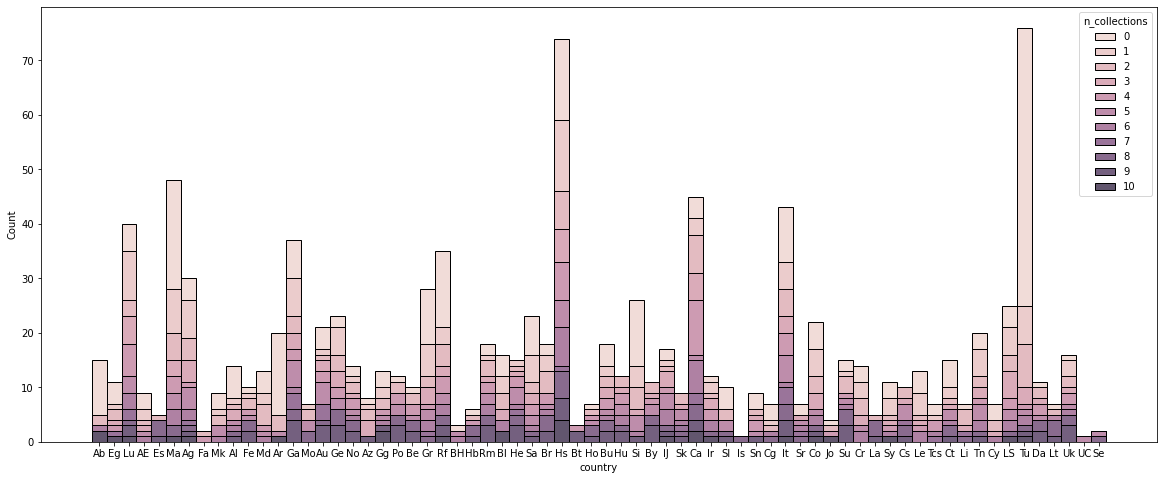

In [59]:
dc_per_countries_rarely_cult = dc_per_countries[dc_per_countries["n_collections"] < 11]

fig, ax = plt.subplots(figsize=(20, 8))
sns.histplot(data=dc_per_countries_rarely_cult, ax=ax, stat="count", multiple="stack",
             x="country", kde=False, hue="n_collections",
             element="bars", legend=True)

Again, we see a circum-mediterranean (+Macaronesian) dominance (most species per region in Spain, Türkiye, Madeira, Canaries, Italy, Portugal). Again, here is a list:

In [75]:
important_columns = ["genus_x", "species", "n_collections", "euro_med_id", "bgci_id", "iucn_red_list",
                     "category", "population_trend"]

dc_plants_melt_concat_dist_df = dc_plants_df.loc[:, important_columns].drop_duplicates()
dc_plants_melt_concat_dist_df["countries"] = dc_plants_melt_concat_dist_df["euro_med_id"].apply(
    lambda x : ", ".join(dc_plants_df["country"][dc_plants_df["euro_med_id"]==x]))

In [76]:
dc_plants_melt_concat_dist_df[
    dc_plants_melt_concat_dist_df["n_collections"] < 11].sort_values(
    by=["countries", "n_collections"])

genus_x              species  n_collections  \
7944            Anacamptis               sancta              3   
8382              Erysimum          leptocarpum              0   
128                 Seseli          cuneifolium              0   
1571            Astragalus            igniarius              0   
1581            Astragalus            albanicus              0   
1583            Astragalus       schachbuzensis              0   
1594            Astragalus          maraziensis              0   
340             Tragopogon           sosnowskyi              0   
1716              Medicago            papillosa              2   
228              Centaurea       rhizocalathium              0   
1674             Hedysarum             formosum              2   
852                Zostera               noltii              0   
1918               Populus           euphratica             10   
1962          Kosteletzkya          pentacarpos             10   
1452            Ranunculus    ophioglossifolius              6   
295             Psephellus           ruprechtii              0   
1590            Astragalus             cuscutae              0   
15555                Vicia              fulgens              1   
15721            Thymelaea             velutina              3   
14733           Bellevalia              ciliata              7   
15383              Genista        aspalathoides              5   
15606              Quercus               afares              9   
21784               Tulipa             albanica              1   
21703         Dactylorhiza            sambucina              9   
22382             Lathyrus             bauhinii              3   
21730               Orchis           pauciflora              3   
21642               Crocus             cvijicii              5   
21286            Cerastium            dinaricum              0   
27716            Centaurea       caroli-henrici              0   
27733            Centaurea            vavilovii              0   
27834              Sonchus           araraticus              0   
28173           Gypsophila            szovitsii              0   
28186               Silene           chustupica              0   
28626            Colchicum             greuteri              0   
29333             Polygala               urartu              0   
29577                Pyrus            voronovii              0   
29582                Pyrus          theodorovii              0   
28926              Papaver             roseolum              2   
27770              Jurinea        coronopifolia              0   
27759             Cousinia            fedorovii              0   
27803           Psephellus             taochius              0   
28142            Verbascum      transcaucasicum              0   
35464           Gymnadenia   archiducis-joannis              0   
35467           Gymnadenia      lithopolitanica              0   
35471           Gymnadenia             stiriaca              0   
35457            Epipactis             albensis              1   
35472           Gymnadenia              widderi              0   
36583               Urtica           kioviensis              3   
36466                 Rosa             rhaetica              7   
35475       Himantoglossum           adriaticum              3   
34553            Artemisia             pancicii              7   
41297            Grammitis              azorica              0   
41573              Lactuca           watsoniana              3   
41631             Myosotis              azorica              3   
42362          Platanthera            micrantha              3   
41256              Isoetes              azorica              2   
63851               Daphne          rodriguezii              6   
63530              Genista               lucida              3   
63887              Rhamnus  ludovici-salvatoris             10   
70881               Sorbus         eminentoides            

# Conclusion a.k.a Starting point

We see atterns in the number of ex situ collections for plants of Emurope. From this dataset, one could start discussing an idea of a living collection of rarely cultivated endangered plants of Europe/Mediterranean.

---
## Coutry-keys

As the country keys of Euro+Med can be a bit confusing, here is the translation again:

In [7]:
key_file = "../../cache/euromed_countries.json"
json.load(open(key_file, "r"))

{'Ab': 'Azerbaijan',
 'Eg': 'Egypt (without Sn)',
 'Lu': 'Portugal (without Az, Md and Sg)',
 'AE': 'East Aegean Islands',
 'Es': 'Estonia',
 'Ma': 'Morocco, with Spanish Territories',
 'Ag': 'Algeria',
 'Fa': 'Faeroe Islands',
 'Mk': 'The Former Yugoslav Republic of Makedonija',
 'Al': 'Albania',
 'Fe': 'Finland',
 'Md': 'Madeira',
 'Ar': 'Armenia',
 'Ga': 'France, with Channel Islands and Monaco (without Co)',
 'Mo': 'Moldavia',
 'Au': 'Austria, with Liechtenstein',
 'Ge': 'Germany',
 'No': 'Norway (without Sb)',
 'Az': 'Azores',
 'Gg': 'Georgia',
 'Po': 'Poland',
 'Be': 'Belgium, with Luxemburg',
 'Gr': 'Greece (without Cr and AE(G))',
 'Rf': 'European part of the Russian Federation',
 'BH': 'Bosnia-Herzegovina',
 'Hb': 'Ireland with N. Ireland',
 'Rm': 'Romania',
 'Bl': 'Balearic Islands',
 'He': 'Switzerland',
 'Sa': 'Sardinia',
 'Br': 'United Kingdom (excluding Channel Islands and Hb(N))',
 'Hs': 'Spain, with Gibraltar and Andorra (without Bl and Ca)',
 'Sb': 'Svalbard: Spitsberg